In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 5, 9]
linestyles = ['--', '-.', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1215

nband = 165

nv = 200

dv = 0.005

tsfc =257

ng =7

nref =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

ng_refs = (/ 7 /) 

data wgt
     &     /0.5 , 0.5 , 0.5 , 0.5,
     &     0.5 , 0.5 , 0.9/

option_wgt_flux =2

option_wgt_k =1

option_klin =1

klin =5e-25

atmosphere_profiles/saw75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

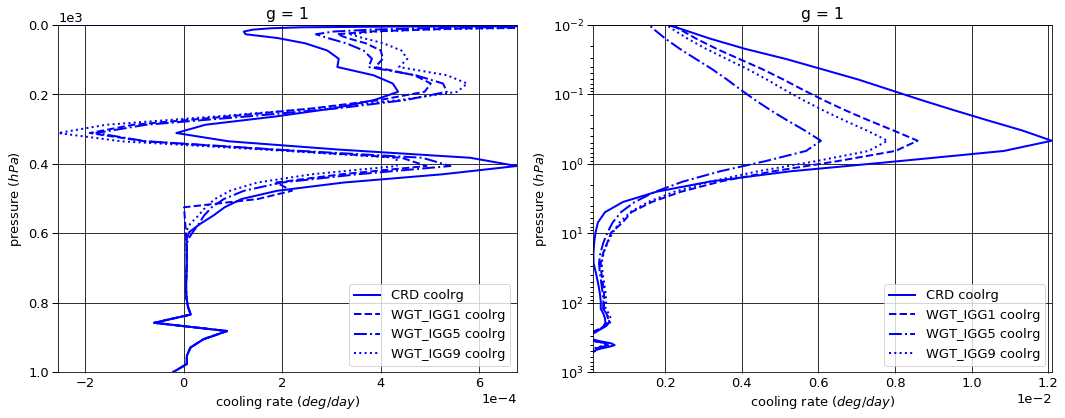

# Figure: cooling rate g-group 2

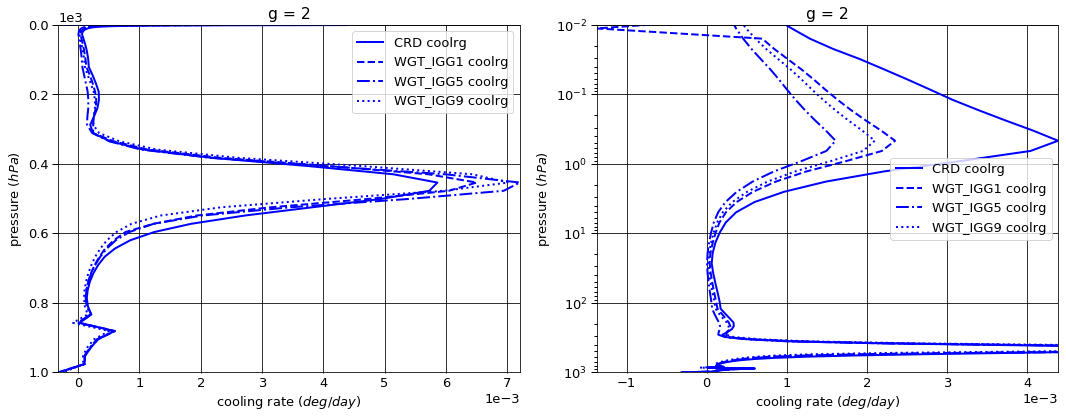

# Figure: cooling rate g-group 3

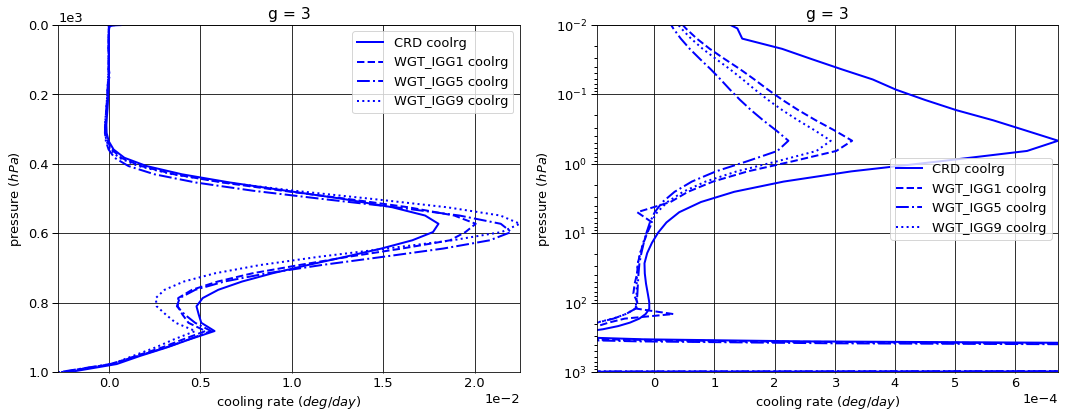

# Figure: cooling rate g-group 4

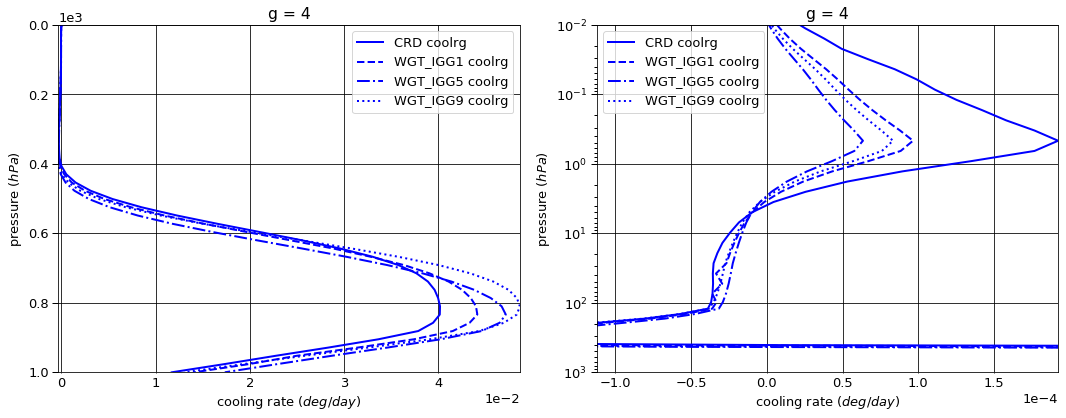

# Figure: cooling rate g-group 5

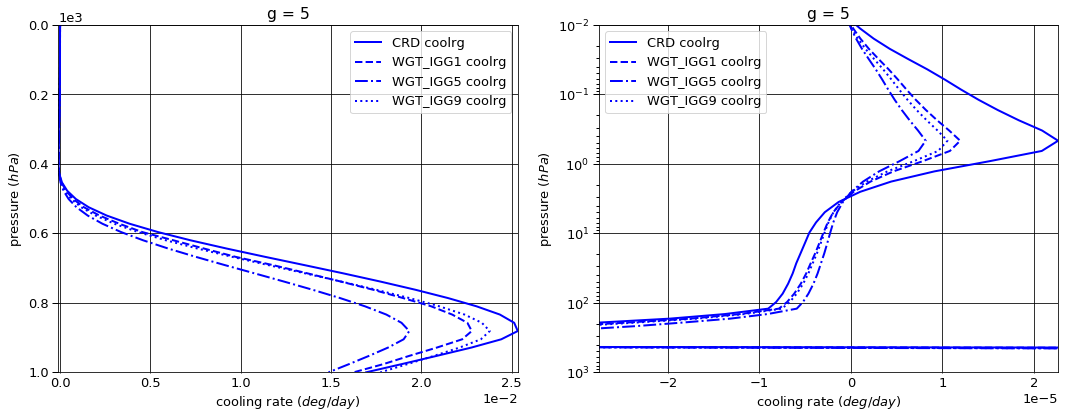

# Figure: cooling rate g-group 6

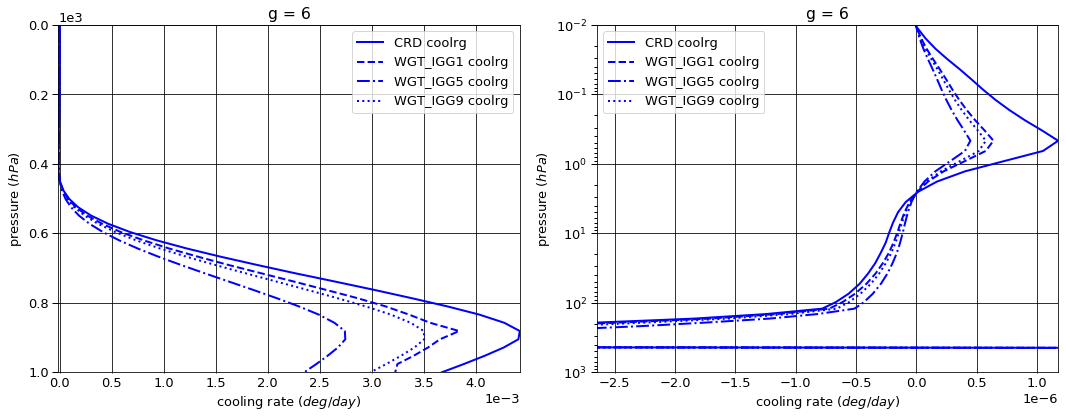

# Figure: cooling rate g-group 7

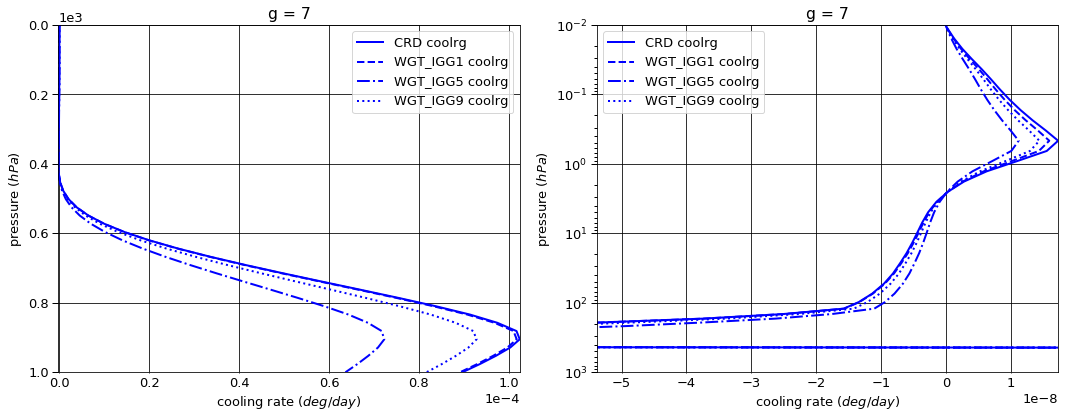

# Figure: cooling rate g-group total

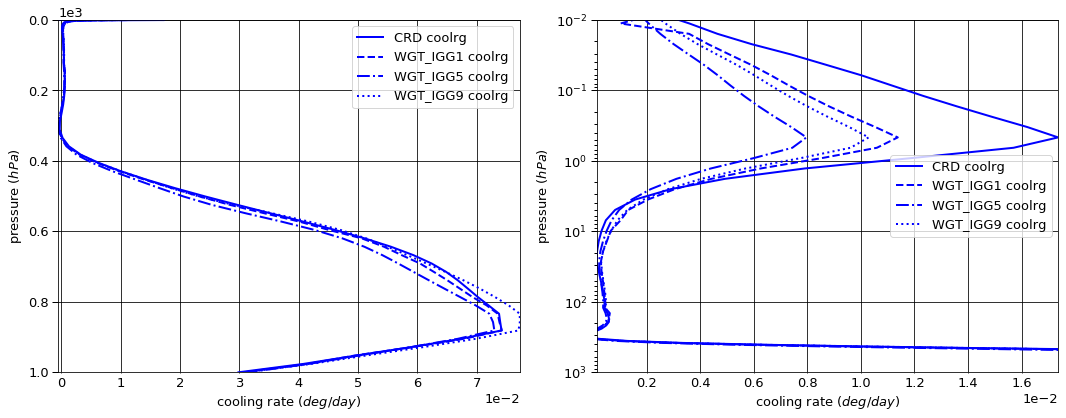

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.020793  0.000000 -0.020793
  1013.0   76    -0.075430  0.075505  0.000075
2 0.0      1     -0.129529  0.000000 -0.129529
  1013.0   76    -0.316080  0.317239  0.001159
3 0.0      1     -0.589778  0.000000 -0.589778
  1013.0   76    -0.920559  0.935693  0.015134
4 0.0      1     -2.124988  0.000000 -2.124988
  1013.0   76    -2.414840  2.030625 -0.384216
5 0.0      1     -2.978172  0.000000 -2.978172
  1013.0   76    -3.043300  0.999512 -2.043789
6 0.0      1     -2.418273  0.000000 -2.418273
  1013.0   76    -2.425048  0.162719 -2.262329
7 0.0      1     -0.362638  0.000000 -0.362638
  1013.0   76    -0.362772  0.003700 -0.359072


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.019220  0.000000 -0.019220
  1013.0   76    -0.075430  0.075505  0.000075
2 0.0      1     -0.124365  0.000000 -0.124365
  1013.0   76    -0.316080  0.317222  0.001142
3 0.0      1     -0.582405  0.000000 -0.582405
  1013.0   76    -0.920559  0.936251  0.015691
4 0.0      1     -2.143086  0.000000 -2.143086
  1013.0   76    -2.414840  2.097939 -0.316902
5 0.0      1     -2.988792  0.000000 -2.988792
  1013.0   76    -3.043300  0.891863 -2.151437
6 0.0      1     -2.419075  0.000000 -2.419075
  1013.0   76    -2.425048  0.137902 -2.287146
7 0.0      1     -0.362639  0.000000 -0.362639
  1013.0   76    -0.362772  0.003677 -0.359095


WGT_IGG5


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.019077  0.000000 -0.019077
  1013.0   76    -0.075430  0.075505  0.000075
2 0.0      1     -0.128482  0.000000 -0.128482
  1013.0   76    -0.316080  0.317146  0.001066
3 0.0      1     -0.599592  0.000000 -0.599592
  1013.0   76    -0.920559  0.937358  0.016799
4 0.0      1     -2.194091  0.000000 -2.194091
  1013.0   76    -2.414840  2.057598 -0.357242
5 0.0      1     -3.005078  0.000000 -3.005078
  1013.0   76    -3.043300  0.732446 -2.310854
6 0.0      1     -2.420910  0.000000 -2.420910
  1013.0   76    -2.425048  0.101068 -2.323980
7 0.0      1     -0.362679  0.000000 -0.362679
  1013.0   76    -0.362772  0.002607 -0.360165


WGT_IGG9


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.018906  0.000000 -0.018906
  1013.0   76    -0.075430  0.075505  0.000075
2 0.0      1     -0.120802  0.000000 -0.120802
  1013.0   76    -0.316080  0.316910  0.000830
3 0.0      1     -0.570240  0.000000 -0.570240
  1013.0   76    -0.920559  0.934241  0.013682
4 0.0      1     -2.136339  0.000000 -2.136339
  1013.0   76    -2.414840  2.226278 -0.188562
5 0.0      1     -2.993677  0.000000 -2.993677
  1013.0   76    -3.043300  0.908042 -2.135259
6 0.0      1     -2.419714  0.000000 -2.419714
  1013.0   76    -2.425048  0.129179 -2.295869
7 0.0      1     -0.362652  0.000000 -0.362652
  1013.0   76    -0.362772  0.003348 -0.359424


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      1.573312e-03  0.000000  1.573312e-03
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
2 0.0      1      5.164530e-03  0.000000  5.164530e-03
  1013.0   76     0.000000e+00 -0.000017 -1.689780e-05
3 0.0      1      7.372900e-03  0.000000  7.372900e-03
  1013.0   76     0.000000e+00  0.000557  5.573870e-04
4 0.0      1     -1.809830e-02  0.000000 -1.809830e-02
  1013.0   76     0.000000e+00  0.067314  6.731377e-02
5 0.0      1     -1.061970e-02  0.000000 -1.061970e-02
  1013.0   76     0.000000e+00 -0.107648 -1.076483e-01
6 0.0      1     -8.022000e-04  0.000000 -8.022000e-04
  1013.0   76     0.000000e+00 -0.024817 -2.481740e-02
7 0.0      1     -5.300000e-07  0.000000 -5.300000e-07
  1013.0   76     0.000000e+00 -0.000023 -2.263000e-05


WGT_IGG5 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.001716  0.000000  0.001716
  1013.0   76     0.000000  0.000000  0.000000
2 0.0      1      0.001047  0.000000  0.001047
  1013.0   76     0.000000 -0.000093 -0.000093
3 0.0      1     -0.009814  0.000000 -0.009814
  1013.0   76     0.000000  0.001665  0.001665
4 0.0      1     -0.069103  0.000000 -0.069103
  1013.0   76     0.000000  0.026974  0.026974
5 0.0      1     -0.026906  0.000000 -0.026906
  1013.0   76     0.000000 -0.267066 -0.267066
6 0.0      1     -0.002638  0.000000 -0.002638
  1013.0   76     0.000000 -0.061651 -0.061651
7 0.0      1     -0.000040  0.000000 -0.000040
  1013.0   76     0.000000 -0.001093 -0.001093


WGT_IGG9 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.001887  0.000000  0.001887
  1013.0   76     0.000000  0.000000  0.000000
2 0.0      1      0.008727  0.000000  0.008727
  1013.0   76     0.000000 -0.000329 -0.000329
3 0.0      1      0.019538  0.000000  0.019538
  1013.0   76     0.000000 -0.001452 -0.001452
4 0.0      1     -0.011351  0.000000 -0.011351
  1013.0   76     0.000000  0.195653  0.195653
5 0.0      1     -0.015505  0.000000 -0.015505
  1013.0   76     0.000000 -0.091470 -0.091470
6 0.0      1     -0.001442  0.000000 -0.001442
  1013.0   76     0.000000 -0.033540 -0.033540
7 0.0      1     -0.000014  0.000000 -0.000014
  1013.0   76     0.000000 -0.000351 -0.000351

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -9.999579e-04
  1001.112500 75    -2.204348e-05
2 0.000312    1      3.262921e-06
  1001.112500 75    -3.155727e-04
3 0.000312    1     -1.059909e-05
  1001.112500 75    -2.238931e-03
4 0.000312    1     -3.227151e-05
  1001.112500 75     1.170912e-02
5 0.000312    1     -4.851359e-06
  1001.112500 75     1.695028e-02
6 0.000312    1     -2.071226e-07
  1001.112500 75     3.673816e-03
7 0.000312    1     -3.946929e-09
  1001.112500 75     8.968491e-05


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      2.765494e-04
  1001.112500 75    -2.204348e-05
2 0.000312    1      2.106368e-05
  1001.112500 75    -3.247242e-04
3 0.000312    1     -1.862631e-05
  1001.112500 75    -2.631219e-03
4 0.000312    1     -2.100109e-05
  1001.112500 75     1.408019e-02
5 0.000312    1     -2.837436e-06
  1001.112500 75     1.626295e-02
6 0.000312    1     -1.176258e-07
  1001.112500 75     3.225558e-03
7 0.000312    1     -3.654231e-09
  1001.112500 75     8.914297e-05


WGT_IGG5


coolrg
g pressure    layer              
1 0.000312    1      2.135042e-04
  1001.112500 75    -2.204348e-05
2 0.000312    1     -5.460848e-06
  1001.112500 75    -3.021200e-04
3 0.000312    1     -1.650164e-05
  1001.112500 75    -2.778812e-03
4 0.000312    1     -1.755511e-05
  1001.112500 75     1.733793e-02
5 0.000312    1     -2.105563e-06
  1001.112500 75     1.486644e-02
6 0.000312    1     -8.338460e-08
  1001.112500 75     2.350773e-03
7 0.000312    1     -2.577250e-09
  1001.112500 75     6.366335e-05


WGT_IGG9


coolrg
g pressure    layer              
1 0.000312    1      2.792632e-04
  1001.112500 75    -2.204348e-05
2 0.000312    1      6.512999e-06
  1001.112500 75    -2.359370e-04
3 0.000312    1     -1.853899e-05
  1001.112500 75    -2.659998e-03
4 0.000312    1     -2.150160e-05
  1001.112500 75     1.302183e-02
5 0.000312    1     -2.689226e-06
  1001.112500 75     1.773724e-02
6 0.000312    1     -1.071187e-07
  1001.112500 75     2.987670e-03
7 0.000312    1     -3.306745e-09
  1001.112500 75     8.169277e-05


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.276507e-03
  1001.112500 75     0.000000e+00
2 0.000312    1      1.780075e-05
  1001.112500 75    -9.151470e-06
3 0.000312    1     -8.027214e-06
  1001.112500 75    -3.922883e-04
4 0.000312    1      1.127043e-05
  1001.112500 75     2.371069e-03
5 0.000312    1      2.013923e-06
  1001.112500 75    -6.873270e-04
6 0.000312    1      8.949675e-08
  1001.112500 75    -4.482585e-04
7 0.000312    1      2.926987e-10
  1001.112500 75    -5.419320e-07


WGT_IGG5 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.213462e-03
  1001.112500 75     0.000000e+00
2 0.000312    1     -8.723768e-06
  1001.112500 75     1.345266e-05
3 0.000312    1     -5.902543e-06
  1001.112500 75    -5.398809e-04
4 0.000312    1      1.471640e-05
  1001.112500 75     5.628816e-03
5 0.000312    1      2.745796e-06
  1001.112500 75    -2.083835e-03
6 0.000312    1      1.237380e-07
  1001.112500 75    -1.323043e-03
7 0.000312    1      1.369680e-09
  1001.112500 75    -2.602155e-05


WGT_IGG9 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.279221e-03
  1001.112500 75     0.000000e+00
2 0.000312    1      3.250078e-06
  1001.112500 75     7.963572e-05
3 0.000312    1     -7.939901e-06
  1001.112500 75    -4.210667e-04
4 0.000312    1      1.076991e-05
  1001.112500 75     1.312713e-03
5 0.000312    1      2.162134e-06
  1001.112500 75     7.869590e-04
6 0.000312    1      1.000039e-07
  1001.112500 75    -6.861467e-04
7 0.000312    1      6.401846e-10
  1001.112500 75    -7.992135e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.624171,0.000000,-8.624171
1013.0,76,-9.558030,4.524993,-5.033037



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.639581,0.000000,-8.639581
1013.0,76,-9.558030,4.460359,-5.097671



WGT_IGG5


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.729909,0.000000,-8.729909
1013.0,76,-9.558030,4.223729,-5.334302



WGT_IGG9


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.622332,0.000000,-8.622332
1013.0,76,-9.558030,4.593503,-4.964527



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.01541,0.000000,-0.015410
1013.0,76,0.00000,-0.064634,-0.064634



WGT_IGG5 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.105738,0.000000,-0.105738
1013.0,76,0.000000,-0.301265,-0.301265



WGT_IGG9 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.001839,0.00000,0.001839
1013.0,76,0.000000,0.06851,0.068510


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.001045
1001.112500,75,0.029846



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.000255
1001.112500,75,0.030680



WGT_IGG5


,,coolrg
pressure,layer,
0.000312,1,0.000172
1001.112500,75,0.031516



WGT_IGG9


,,coolrg
pressure,layer,
0.000312,1,0.000243
1001.112500,75,0.030910



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.001300
1001.112500,75,0.000834



WGT_IGG5 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.001216
1001.112500,75,0.001669



WGT_IGG9 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.001288
1001.112500,75,0.001064


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.009818,0.007805
2,0.038636,0.032818
3,0.109424,0.095711
4,0.277121,0.251508
5,0.310485,0.318695
6,0.223394,0.255171
7,0.031121,0.038291


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.448496e-20
2,1.856093e-21
3,2.378385e-22
4,3.047647e-23
5,3.905235e-24
6,5.004142e-25
7,1.858499e-25


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.448496e-20,NaN,0.009818,0.007805,0.009818,0.007805,600.0
2,1.856093e-21,0.128139,0.038636,0.032818,0.048455,0.040623,600.0
3,2.378385e-22,0.128139,0.109424,0.095711,0.157879,0.136334,600.0
4,3.047647e-23,0.128139,0.277121,0.251508,0.435000,0.387842,600.0
5,3.905235e-24,0.128139,0.310485,0.318695,0.745485,0.706538,600.0
6,5.004142e-25,0.128139,0.223394,0.255171,0.968879,0.961709,600.0
7,1.858499e-25,0.371392,0.031121,0.038291,1.000000,1.000000,600.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     2.562622e-20  1.121748e-21  22.844893  1.138944e-06
      2 0.000312     1.628134e-21  7.261266e-23  22.422183  7.241879e-08
      3 0.000312     8.168025e-23  6.348279e-24  12.866519  3.748305e-09
      4 0.000312     1.695204e-23  9.157445e-25  18.511759  7.608206e-10
      5 0.000312     1.418049e-24  9.800046e-26  14.469817  6.455425e-11
      6 0.000312     6.740100e-26  8.587370e-27   7.848852  3.235628e-12
      7 0.000312     8.625565e-27  2.050802e-27   4.205947  6.785715e-13
2     1 0.000750     2.624751e-20  1.129017e-21  23.248094  4.695317e-07
      2 0.000750     1.669466e-21  7.339570e-23  22.746094  2.989162e-08
      3 0.000750     8.373936e-23  6.417573e-24  13.048448  1.546271e-09
      4 0.000750     1.711631e-23  9.256349e-25  18.491421  3.094353e-10
      5 0.000750     1.446415e-24  9.943016e-26  14.547042  2.651261e-11
      6 0.000750     6.923882e-26  8.748549e-27   7.914320  1.337552e-12
      7 0.000750     8.763197e-27  2.078131e-27   4.216865  2.776622e-13
3     1 0.001052     2.753824e-20  1.143348e-21  24.085624  6.898540e-07
      2 0.001052     1.756052e-21  7.492267e-23  23.438193  4.403889e-08
      3 0.001052     8.809725e-23  6.556358e-24  13.436919  2.276624e-09
      4 0.001052     1.746204e-23  9.458180e-25  18.462363  4.427486e-10
      5 0.001052     1.505617e-24  1.023633e-25  14.708567  3.867540e-11
      6 0.001052     7.316481e-26  9.080617e-27   8.057251  1.978180e-12
      7 0.001052     9.058229e-27  2.135712e-27   4.241316  4.024396e-13
4     1 0.001476     2.889522e-20  1.157687e-21  24.959429  1.014063e-06
      2 0.001476     1.848128e-21  7.641670e-23  24.184869  6.493910e-08
      3 0.001476     9.279855e-23  6.696995e-24  13.856745  3.357237e-09
      4 0.001476     1.783284e-23  9.668509e-25  18.444250  6.343501e-10
      5 0.001476     1.568346e-24  1.054316e-25  14.875479  5.647757e-11
      6 0.001476     7.745665e-26  9.429242e-27   8.214516  2.931754e-12
      7 0.001476     9.383056e-27  2.198333e-27   4.268260  5.847309e-13
5     1 0.002070     3.030330e-20  1.171888e-21  25.858532  1.489623e-06
      2 0.002070     1.944818e-21  7.785767e-23  24.979142  9.572697e-08
      3 0.002070     9.781039e-23  6.837809e-24  14.304347  4.952675e-09
      4 0.002070     1.822665e-23  9.884844e-25  18.438988  9.093929e-10
      5 0.002070     1.634088e-24  1.086042e-25  15.046266  8.247622e-11
      6 0.002070     8.209772e-26  9.791402e-27   8.384674  4.348827e-12
      7 0.002070     9.737515e-27  2.266071e-27   4.297092  8.509728e-13
6     1 0.002904     3.176325e-20  1.186001e-21  26.781809  2.187410e-06
      2 0.002904     2.046315e-21  7.924856e-23  25.821479  1.411103e-07
      3 0.002904     1.031545e-22  6.979039e-24  14.780608  7.311457e-09
      4 0.002904     1.864586e-23  1.010718e-24  18.448130  1.304946e-09
      5 0.002904     1.703089e-24  1.118868e-25  15.221533  1.204912e-10
      6 0.002904     8.712264e-26  1.016818e-26   8.568163  6.458868e-12
      7 0.002904     1.012541e-26  2.339671e-27   4.327708  1.241022e-12
7     1 0.004074     3.327584e-20  1.200103e-21  27.727483  3.210616e-06
      2 0.004074     2.152821e-21  8.059602e-23  26.711255  2.079897e-07
      3 0.004074     1.088540e-22  7.121122e-24  15.286075  1.080033e-08
      4 0.004074     1.909311e-23  1.033558e-24  18.473185  1.874321e-09
      5 0.004074     1.775630e-24  1.152863e-25  15.401918  1.760939e-10
      6 0.004074     9.257036e-26  1.056061e-26   8.765624  9.604201e-12
      7 0.004074     1.055102e-26  2.419859e-27   4.360179  1.813709e-12
8     1 0.005714     3.484209e-20  1.214308e-21  28.692965  4.709915e-06
      2 0.005714     2.264561e-21  8.191069e-23  27.646707  3.065110e-07
      3 0.005714     1.149350e-22  7.264722e-24  15.820975  1.596250e-08
      4 0.005714     1.957138e-23  1.057025e-24  18.515536  2.694613e-09
      5 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
